# Description du Notebook

Ce notebook permet d'entraîner un modèle de NER en français avec spaC en se basant les infos de voyage. 

Les étapes incluent : 
- l'importation, le nettoyage et la préparation des données annotées,
- l'entraînement du modèle. 

Ensuite, on fait un comparaison de performances entre le modèle personnalisé et le modèle spaCy préentraîné, avec des visualisations pour évaluer la diversité et le nombre d'entités détectées par chaque modèle.


In [20]:
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm
import time
import subprocess
import pandas as pd
import ast
from random import shuffle
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import spacy
from spacy import displacy

print("Toutes les libraries ont été importées")

Toutes les libraries ont été importées


### Chargement du Modèle spaCy Pré-entraîné

Charge le modèle pré-entraîné en français `fr_core_news_md` de spaCy.

In [6]:
print("Chargement du modèle spacy pré-entraîné...")
models = {
    "sm": "fr_core_news_sm",
    "md": "fr_core_news_md",
    "lg": "fr_core_news_lg"
}
# Dictionnaire pour stocker les modèles chargés
nlp_models = {}
for model_key, model_name in models.items():
    print(f"\nChargement du modèle spaCy pré-entraîné {model_key}...")
    nlp_models[model_key] = spacy.load(model_name)
    print(f"Modèle spaCy {model_key} bien chargé")



Chargement du modèle spacy pré-entraîné...

Chargement du modèle spaCy pré-entraîné sm...
Modèle spaCy sm bien chargé

Chargement du modèle spaCy pré-entraîné md...
Modèle spaCy md bien chargé

Chargement du modèle spaCy pré-entraîné lg...
Modèle spaCy lg bien chargé


### Test de NER sur du Texte Simple

Tester le NER de spaCy sur des phrases simples, en particulier pour l'extraction de villes de départ et d'arrivée.


In [7]:
# Fonction de test pour vérifier la reconnaissance des entités sur du texte simple
def test_ner_recognition(nlp, text):
    print(f"Test pour vérifier la reconnaissance des entités avec spaCy {nlp.meta['name']}...\n")
    doc = nlp(text)
    spacy.displacy.render(doc, style="ent", jupyter=True)

texte_simple = '''Je souhaiterais me rendre de Paris à Marseille.
Quelle est la meilleure façon d'aller à Sannois depuis la gare de Toulouse ?
Je prévois de rendre visite à mon ami Patrick à Paris en partant de Bordeaux.
Comment puis-je aller de Marseille à Bordeaux sans passer par Paris ?
Quels sont les horaires des trains de Nantes à Lyon demain matin ?
Je dois voyager de Lille à Toulouse ce week-end, avez-vous des suggestions de trajet ?
Quel est le moyen le plus rapide pour me rendre de Lyon à Paris ?'''

# on teste chaque modèle
for model_key in models.keys():
    test_ner_recognition(nlp_models[model_key], texte_simple)

Test pour vérifier la reconnaissance des entités avec spaCy core_news_sm...



Test pour vérifier la reconnaissance des entités avec spaCy core_news_md...



Test pour vérifier la reconnaissance des entités avec spaCy core_news_lg...



### Chargement du Dataset

Charge le CSV pour l'entraînement du modèle avec la bibliothèque `pandas` pour lire le fichier, avec le séparateur et l'encodage. Les lignes qui sont mal faites sont ignorées avec `on_bad_lines='skip'`. 

In [8]:
def load_dataset(file_path):
    print("Chargement du dataset csv pour l'entraînement...")
    df = pd.read_csv(file_path, sep=',', encoding='utf-8', on_bad_lines='skip')
    print("\nDataset bien chargé")
    return df

df = load_dataset('../../dataset/raw/initial_training_data.csv')

print("\nAperçu du dataset : \n")
display(df)

Chargement du dataset csv pour l'entraînement...

Dataset bien chargé

Aperçu du dataset : 



,text,entities
0,Je voudrais aller de Toulouse à Bordeaux.,"[{'start': 21, 'end': 29, 'label': 'DEPARTURE'..."
1,Comment me rendre à Port-Boulet depuis la gare...,"[{'start': 20, 'end': 31, 'label': 'DESTINATIO..."
2,Je veux aller voir mon ami Albert à Tours en p...,"[{'start': 36, 'end': 41, 'label': 'DESTINATIO..."
3,Y a-t-il des trains de Nantes à Montaigu ?,"[{'start': 23, 'end': 29, 'label': 'DEPARTURE'..."
4,Je souhaite me rendre à Paris en partant de To...,"[{'start': 25, 'end': 30, 'label': 'DESTINATIO..."
...,...,...
211,Je pars de Lyon pour rejoindre Rennes,"[{'start': 12, 'end': 16, 'label': 'DEPARTURE'..."
212,Je souhaite me rendre à Lyon en partant de Toulon,"[{'start': 25, 'end': 29, 'label': 'DESTINATIO..."
213,Je pars de Lyon pour rejoindre Nîmes,"[{'start': 12, 'end': 16, 'label': 'DEPARTURE'..."
214,Je souhaite me rendre à Lyon en partant de Nice,"[{'start': 25, 'end': 29, 'label': 'DESTINATIO..."


## Nettoyage des Données

Préparation des textes en supprimant les retours à la ligne et les espaces.


In [9]:
print("Nettoyage des données...\n") # pour supprimer des retours à la ligne, espaces inutiles, etc.
def clean_text(text):
    return text.replace('\r', '').strip()

df['text'] = df['text'].apply(clean_text)
print("Données ont été nettoyées")

Nettoyage des données...

Données ont été nettoyées


### Vérification de l'alignement des entités nommées

Pour s'assurer que les indices de début et de fin spécifiés pour chaque entité correspondent bien au texte fourni. Pour chaque entité :

- Les indices `start` et `end`.
- Si l'extrait de texte aux indices correspond à celui attendu, l'entité est ajoutée à la liste `verified_entities`.
- Si une incohérence est détectée, l'entité est ignorée et un message d'avertissement est affiché.

In [10]:
def verify_entity_alignment(text, entities):
    print("Vérification de l'alignement des entités\n")
    verified_entities = []
    for ent in entities:
        start, end, label = ent['start'], ent['end'], ent['label']
        if text[start:end] == text[start:end]:
            verified_entities.append(ent)
        else:
            print(f"Skipping entity: {text[start:end]} in text: {text}")
    print("Vérification terminée")
    return verified_entities

### Préparation du Dataset pour spaCy

Conversion du dataset CSV au format spaCy avec objets Doc avec les entités labelisés. On mélange les données pour éviter un apprentissage biaisé. Chaque texte est ensuite vérifié pour s'assurer que les indices des entités sont corrects avant d’ajouter les annotations d’entités.


In [11]:
def prepare_data_for_spacy(df):
    print("Conversion du dataset csv au format spaCy...\n")
    db = DocBin()
    data = list(zip(df['text'], df['entities']))
    print("On mélange des données pour éviter l'apprentissage biaisé\n")
    shuffle(data)

    for text, entities in data:
        entities = ast.literal_eval(entities)
        verified_entities = verify_entity_alignment(text, entities)

        if verified_entities:
            doc = nlp_models["sm"].make_doc(text)
            doc.ents = create_entity_spans(doc, verified_entities)
            db.add(doc)

    print("Dataset a été bien converti au format spaCy\n")
    return db

### Création de Spans d'Entités

Génération des spans d'entités à partir d'entités vérifiées dans un texte donné. Pour chaque entité, on identifie les indices de début et de fin et le label associée ("DEPARTURE", "DESTINATION"). 
Les entités correctes sont ajoutées sous forme de spans dans `doc`. Ca facilite l'annotation des textes pour l'entraînement du modèle de reconnaissance d'entités. 

In [12]:
def create_entity_spans(doc, verified_entities):
    print("Création de span d'entités\n")
    ents = []
    for ent in verified_entities:
        start, end, label = ent['start'], ent['end'], ent['label']
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span:
            ents.append(span)
    return ents

In [13]:
print("Préparation des données pour la conversion au format spaCy...\n")
db = prepare_data_for_spacy(df)

print("Sauvegarde des données au format spaCy...\n")
db.to_disk("../../dataset/processed/processed_training_data.spacy")
print("Sauvegardé !")

Préparation des données pour la conversion au format spaCy...

Conversion du dataset csv au format spaCy...

On mélange des données pour éviter l'apprentissage biaisé

Vérification de l'alignement des entités

Vérification terminée
Création de span d'entités

Vérification de l'alignement des entités

Vérification terminée
Création de span d'entités

Vérification de l'alignement des entités

Vérification terminée
Création de span d'entités

Vérification de l'alignement des entités

Vérification terminée
Création de span d'entités

Vérification de l'alignement des entités

Vérification terminée
Création de span d'entités

Vérification de l'alignement des entités

Vérification terminée
Création de span d'entités

Vérification de l'alignement des entités

Vérification terminée
Création de span d'entités

Vérification de l'alignement des entités

Vérification terminée
Création de span d'entités

Vérification de l'alignement des entités

Vérification terminée
Création de span d'entités

Véri

### Entraînement du Modèle

Automatise la configuration et l'entraînement du modèle spaCy pour l'extraction d'entités en français. On génère un fichier de configuration et on lance l'entraînement avec les données préparées. 
Le modèle est ensuite sauvegardé une utilisation ultérieure.


In [14]:
# Fonction pour entraîner le modèle
def train_model(config_path, output_path, training_data_path):
    print("Génération de la configuration...\n")
    subprocess.run(f"python -m spacy init config {config_path} --lang fr --pipeline ner --optimize efficiency --force", shell=True)
    print("Configuration faite.\n")

    print("Début de l'entraînement du modèle...\n")
    
    # Lancer le processus d'entraînement
    process = subprocess.Popen(f"python -m spacy train {config_path} --output {output_path} --paths.train {training_data_path} --paths.dev {training_data_path}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    with tqdm(total=100, desc="Entraînement du modèle") as pbar:
        while True:
            output = process.stdout.readline()
            if output == b"" and process.poll() is not None:
                break
            if output:
                print(output.decode().strip()) 
            pbar.update(1)
            time.sleep(1)

# Entraîner chaque modèle pré-entraîné
for model_key in models.keys():
    print(f"Lancement de l'entraînement pour le modèle {model_key}...")
    train_model('./configuration.cfg', f'../../models/saved_models/{model_key}', '../../dataset/processed/processed_training_data.spacy')
    print(f"Entraînement du modèle {model_key} terminé.\n")

Lancement de l'entraînement pour le modèle sm...
Génération de la configuration...

Configuration faite.

Début de l'entraînement du modèle...



Entraînement du modèle:   1%|          | 1/100 [00:03<06:06,  3.71s/it]

✔ Created output directory: ..\..\models\saved_models\sm


Entraînement du modèle:   2%|▏         | 2/100 [00:04<03:27,  2.12s/it]

ℹ Saving to output directory: ..\..\models\saved_models\sm


Entraînement du modèle:   3%|▎         | 3/100 [00:05<02:35,  1.61s/it]

ℹ Using CPU


Entraînement du modèle:   4%|▍         | 4/100 [00:06<02:11,  1.37s/it]

Entraînement du modèle:   5%|▌         | 5/100 [00:07<01:57,  1.24s/it]

=========================== Initializing pipeline ===========================


Entraînement du modèle:   6%|▌         | 6/100 [00:08<01:54,  1.22s/it]

✔ Initialized pipeline


Entraînement du modèle:   7%|▋         | 7/100 [00:09<01:46,  1.15s/it]

Entraînement du modèle:   8%|▊         | 8/100 [00:10<01:41,  1.10s/it]

============================= Training pipeline =============================


Entraînement du modèle:   9%|▉         | 9/100 [00:11<01:37,  1.07s/it]

ℹ Pipeline: ['tok2vec', 'ner']


Entraînement du modèle:  10%|█         | 10/100 [00:12<01:34,  1.05s/it]

ℹ Initial learn rate: 0.001


Entraînement du modèle:  11%|█         | 11/100 [00:13<01:32,  1.03s/it]

E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE


Entraînement du modèle:  12%|█▏        | 12/100 [00:14<01:30,  1.02s/it]

---  ------  ------------  --------  ------  ------  ------  ------


Entraînement du modèle:  13%|█▎        | 13/100 [00:15<01:28,  1.02s/it]

0       0          0.00     50.79    0.00    0.00    0.00    0.00


Entraînement du modèle:  14%|█▍        | 14/100 [00:20<03:10,  2.21s/it]

8     200         54.61   1379.36   90.16   92.55   87.88    0.90


Entraînement du modèle:  15%|█▌        | 15/100 [00:34<08:03,  5.69s/it]

18     400        155.20    213.92   96.97   96.97   96.97    0.97


Entraînement du modèle:  16%|█▌        | 16/100 [00:48<11:37,  8.30s/it]

31     600        241.93     75.22  100.00  100.00  100.00    1.00


Entraînement du modèle:  17%|█▋        | 17/100 [01:05<14:56, 10.80s/it]

46     800         18.39      6.11  100.00  100.00  100.00    1.00


Entraînement du modèle:  18%|█▊        | 18/100 [01:22<17:08, 12.54s/it]

65    1000         32.83      4.98  100.00  100.00  100.00    1.00


Entraînement du modèle:  19%|█▉        | 19/100 [01:41<19:48, 14.67s/it]

88    1200        119.71     33.20   98.98  100.00   97.98    0.99


Entraînement du modèle:  20%|██        | 20/100 [02:04<22:34, 16.94s/it]

116    1400        199.03     49.47  100.00  100.00  100.00    1.00


Entraînement du modèle:  21%|██        | 21/100 [02:27<24:54, 18.91s/it]

150    1600         74.56     12.96  100.00  100.00  100.00    1.00


Entraînement du modèle:  22%|██▏       | 22/100 [02:57<29:01, 22.33s/it]

190    1800         73.06     14.03  100.00  100.00  100.00    1.00


Entraînement du modèle:  23%|██▎       | 23/100 [03:27<31:32, 24.58s/it]

240    2000         29.87      3.67  100.00  100.00  100.00    1.00


Entraînement du modèle:  24%|██▍       | 24/100 [04:07<36:53, 29.12s/it]

302    2200        206.65     20.38  100.00  100.00  100.00    1.00


Entraînement du modèle:  25%|██▌       | 25/100 [04:08<25:51, 20.68s/it]

✔ Saved pipeline to output directory


Entraînement du modèle:  26%|██▌       | 26/100 [04:09<18:13, 14.78s/it]

..\..\models\saved_models\sm\model-last


Entraînement du modèle:  26%|██▌       | 26/100 [04:10<11:52,  9.63s/it]


Entraînement du modèle sm terminé.

Lancement de l'entraînement pour le modèle md...
Génération de la configuration...

Configuration faite.

Début de l'entraînement du modèle...



Entraînement du modèle:   1%|          | 1/100 [00:03<06:12,  3.76s/it]

✔ Created output directory: ..\..\models\saved_models\md


Entraînement du modèle:   2%|▏         | 2/100 [00:04<03:29,  2.14s/it]

ℹ Saving to output directory: ..\..\models\saved_models\md


Entraînement du modèle:   3%|▎         | 3/100 [00:05<02:37,  1.62s/it]

ℹ Using CPU


Entraînement du modèle:   4%|▍         | 4/100 [00:06<02:12,  1.38s/it]

Entraînement du modèle:   5%|▌         | 5/100 [00:07<01:57,  1.24s/it]

=========================== Initializing pipeline ===========================


Entraînement du modèle:   6%|▌         | 6/100 [00:09<02:18,  1.47s/it]

✔ Initialized pipeline


Entraînement du modèle:   7%|▋         | 7/100 [00:10<02:02,  1.32s/it]

Entraînement du modèle:   8%|▊         | 8/100 [00:11<01:51,  1.22s/it]

============================= Training pipeline =============================


Entraînement du modèle:   9%|▉         | 9/100 [00:12<01:44,  1.15s/it]

ℹ Pipeline: ['tok2vec', 'ner']


Entraînement du modèle:  10%|█         | 10/100 [00:13<01:39,  1.10s/it]

ℹ Initial learn rate: 0.001


Entraînement du modèle:  11%|█         | 11/100 [00:14<01:35,  1.07s/it]

E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE


Entraînement du modèle:  12%|█▏        | 12/100 [00:15<01:32,  1.05s/it]

---  ------  ------------  --------  ------  ------  ------  ------


Entraînement du modèle:  13%|█▎        | 13/100 [00:16<01:30,  1.04s/it]

0       0          0.00     50.79    0.00    0.00    0.00    0.00


Entraînement du modèle:  14%|█▍        | 14/100 [00:22<03:43,  2.60s/it]

8     200         54.61   1379.36   90.16   92.55   87.88    0.90


Entraînement du modèle:  15%|█▌        | 15/100 [00:35<08:06,  5.73s/it]

18     400        155.20    213.92   96.97   96.97   96.97    0.97


Entraînement du modèle:  16%|█▌        | 16/100 [00:49<11:26,  8.17s/it]

31     600        241.93     75.22  100.00  100.00  100.00    1.00


Entraînement du modèle:  17%|█▋        | 17/100 [01:04<13:58, 10.10s/it]

46     800         18.39      6.11  100.00  100.00  100.00    1.00


Entraînement du modèle:  18%|█▊        | 18/100 [01:19<15:55, 11.66s/it]

65    1000         32.83      4.98  100.00  100.00  100.00    1.00


Entraînement du modèle:  19%|█▉        | 19/100 [01:36<17:57, 13.30s/it]

88    1200        119.71     33.20   98.98  100.00   97.98    0.99


Entraînement du modèle:  20%|██        | 20/100 [01:55<19:44, 14.81s/it]

116    1400        199.03     49.47  100.00  100.00  100.00    1.00


Entraînement du modèle:  21%|██        | 21/100 [02:16<21:58, 16.69s/it]

150    1600         74.56     12.96  100.00  100.00  100.00    1.00


Entraînement du modèle:  22%|██▏       | 22/100 [02:40<24:40, 18.97s/it]

190    1800         73.06     14.03  100.00  100.00  100.00    1.00


Entraînement du modèle:  23%|██▎       | 23/100 [03:10<28:26, 22.17s/it]

240    2000         29.87      3.67  100.00  100.00  100.00    1.00


Entraînement du modèle:  24%|██▍       | 24/100 [03:51<35:22, 27.93s/it]

302    2200        206.65     20.38  100.00  100.00  100.00    1.00


Entraînement du modèle:  25%|██▌       | 25/100 [03:52<24:48, 19.85s/it]

✔ Saved pipeline to output directory


Entraînement du modèle:  26%|██▌       | 26/100 [03:53<17:30, 14.19s/it]

..\..\models\saved_models\md\model-last


Entraînement du modèle:  26%|██▌       | 26/100 [03:54<11:07,  9.02s/it]


Entraînement du modèle md terminé.

Lancement de l'entraînement pour le modèle lg...
Génération de la configuration...

Configuration faite.

Début de l'entraînement du modèle...



Entraînement du modèle:   1%|          | 1/100 [00:05<08:45,  5.31s/it]

✔ Created output directory: ..\..\models\saved_models\lg


Entraînement du modèle:   2%|▏         | 2/100 [00:06<04:32,  2.78s/it]

ℹ Saving to output directory: ..\..\models\saved_models\lg


Entraînement du modèle:   3%|▎         | 3/100 [00:07<03:10,  1.97s/it]

ℹ Using CPU


Entraînement du modèle:   4%|▍         | 4/100 [00:08<02:32,  1.59s/it]

Entraînement du modèle:   5%|▌         | 5/100 [00:09<02:10,  1.38s/it]

=========================== Initializing pipeline ===========================


Entraînement du modèle:   6%|▌         | 6/100 [00:14<04:05,  2.61s/it]

✔ Initialized pipeline


Entraînement du modèle:   7%|▋         | 7/100 [00:15<03:13,  2.09s/it]

Entraînement du modèle:   8%|▊         | 8/100 [00:16<02:40,  1.74s/it]

============================= Training pipeline =============================


Entraînement du modèle:   9%|▉         | 9/100 [00:17<02:17,  1.51s/it]

ℹ Pipeline: ['tok2vec', 'ner']


Entraînement du modèle:  10%|█         | 10/100 [00:18<02:01,  1.35s/it]

ℹ Initial learn rate: 0.001


Entraînement du modèle:  11%|█         | 11/100 [00:19<01:50,  1.25s/it]

E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE


Entraînement du modèle:  12%|█▏        | 12/100 [00:20<01:43,  1.17s/it]

---  ------  ------------  --------  ------  ------  ------  ------


Entraînement du modèle:  13%|█▎        | 13/100 [00:21<01:37,  1.12s/it]

0       0          0.00     50.79    0.00    0.00    0.00    0.00


Entraînement du modèle:  14%|█▍        | 14/100 [00:37<08:13,  5.74s/it]

8     200         54.61   1379.36   90.16   92.55   87.88    0.90


Entraînement du modèle:  15%|█▌        | 15/100 [00:58<14:43, 10.39s/it]

18     400        155.20    213.92   96.97   96.97   96.97    0.97


Entraînement du modèle:  16%|█▌        | 16/100 [01:23<20:36, 14.72s/it]

31     600        241.93     75.22  100.00  100.00  100.00    1.00


Entraînement du modèle:  17%|█▋        | 17/100 [01:51<25:49, 18.67s/it]

46     800         18.39      6.11  100.00  100.00  100.00    1.00


Entraînement du modèle:  18%|█▊        | 18/100 [02:11<25:51, 18.92s/it]

65    1000         32.83      4.98  100.00  100.00  100.00    1.00


Entraînement du modèle:  19%|█▉        | 19/100 [02:33<26:57, 19.96s/it]

88    1200        119.71     33.20   98.98  100.00   97.98    0.99


Entraînement du modèle:  20%|██        | 20/100 [02:57<28:07, 21.10s/it]

116    1400        199.03     49.47  100.00  100.00  100.00    1.00


Entraînement du modèle:  21%|██        | 21/100 [03:26<30:49, 23.41s/it]

150    1600         74.56     12.96  100.00  100.00  100.00    1.00


Entraînement du modèle:  22%|██▏       | 22/100 [04:07<37:23, 28.76s/it]

190    1800         73.06     14.03  100.00  100.00  100.00    1.00


Entraînement du modèle:  23%|██▎       | 23/100 [04:45<40:37, 31.66s/it]

240    2000         29.87      3.67  100.00  100.00  100.00    1.00


Entraînement du modèle:  24%|██▍       | 24/100 [05:32<45:55, 36.25s/it]

302    2200        206.65     20.38  100.00  100.00  100.00    1.00


Entraînement du modèle:  25%|██▌       | 25/100 [05:33<32:05, 25.68s/it]

✔ Saved pipeline to output directory


Entraînement du modèle:  26%|██▌       | 26/100 [05:34<22:32, 18.27s/it]

..\..\models\saved_models\lg\model-last


Entraînement du modèle:  26%|██▌       | 26/100 [05:35<15:55, 12.91s/it]

Entraînement du modèle lg terminé.



# Test du Modèle d'Extraction d'Entités

Charge le modèle NER et teste son efficacité sur plusieurs textes relatifs aux voyages. 
On utilise `spaCy` pour afficher les entités détectées (départs et destinations).

In [22]:
# Fonction pour charger et tester le modèle sur un texte donné
def load_and_test_model(model_path, text):
    print("Chargement et test du modèle")
    nlp_model = spacy.load(model_path)
    doc = nlp_model(text)
    return doc

def test_model_on_texts(model_paths):
    # Textes de test
    texts = [
        '''Je souhaite me rendre à Lille en partant d'Aubervilliers pour assister à une conférence.
        Je compte me rendre à Bordeaux depuis Marseille pour rendre visite à ma soeur Paris.
        Je dois regarder les trains Toulouse - Brest pour aller voir mon ami Albert.
        Je dois planifier un voyage Nice Toulouse pour les prochaines vacances.
        Une réunion de travail m'oblige à faire Paris - Clermont-Ferrand la semaine prochaine.''',

        '''Je souhaite me rendre à Lille en partant d'Aubervilliers pour assister à une conférence avec une escale à Nice.
        Je compte me rendre à Bordeaux depuis Marseille en m'arrêtant à Toulouse pour rendre visite à ma soeur Paris.
        Je dois regarder les trains Toulouse - Brest pour aller voir mon ami Albert en faisant une escale à Tours.
        Je dois planifier un voyage Nice Toulouse en passant par Aubervilliers pour les prochaines vacances.
        Une réunion de travail m'oblige à faire Paris - Clermont-Ferrand avec un arrêt par Lyon la semaine prochaine.'''
    ]

    # Dictionnaire des couleurs par type d'entité
    colors = {
        "DEPARTURE": "#1f77b4", 
        "DESTINATION": "#2ca02c",
        "STOP": "#9467bd"  
    }
    options = {"colors": colors}

    # Tester chaque modèle sur chaque texte
    for model_key, model_path in model_paths.items():
        print(f"Test du modèle {model_key}...")
        for text in texts:
            doc = load_and_test_model(model_path, text)
            displacy.render(doc, style="ent", jupyter=True, options=options)

# Chemins des modèles
model_paths = {key: f"../../models/saved_models/{key}/model-best/" for key in models.keys()}

# Exécution des tests
test_model_on_texts(model_paths)

Test du modèle sm...
Chargement et test du modèle


Chargement et test du modèle


Test du modèle md...
Chargement et test du modèle


Chargement et test du modèle


Test du modèle lg...
Chargement et test du modèle


Chargement et test du modèle


Chargement et test du modèle
Chargement et test du modèle
Chargement et test du modèle
Chargement et test du modèle
Chargement et test du modèle
Chargement et test du modèle
Chargement et test du modèle
Chargement et test du modèle
Chargement et test du modèle
Chargement et test du modèle
Chargement et test du modèle
Chargement et test du modèle
Chargement et test du modèle
Chargement et test du modèle
Chargement et test du modèle

Modèle : sm
  Précision moyenne: 0.60
  Rappel moyen: 0.50
  F1-score moyen: 0.53

Modèle : md
  Précision moyenne: 0.60
  Rappel moyen: 0.50
  F1-score moyen: 0.53

Modèle : lg
  Précision moyenne: 0.60
  Rappel moyen: 0.50
  F1-score moyen: 0.53


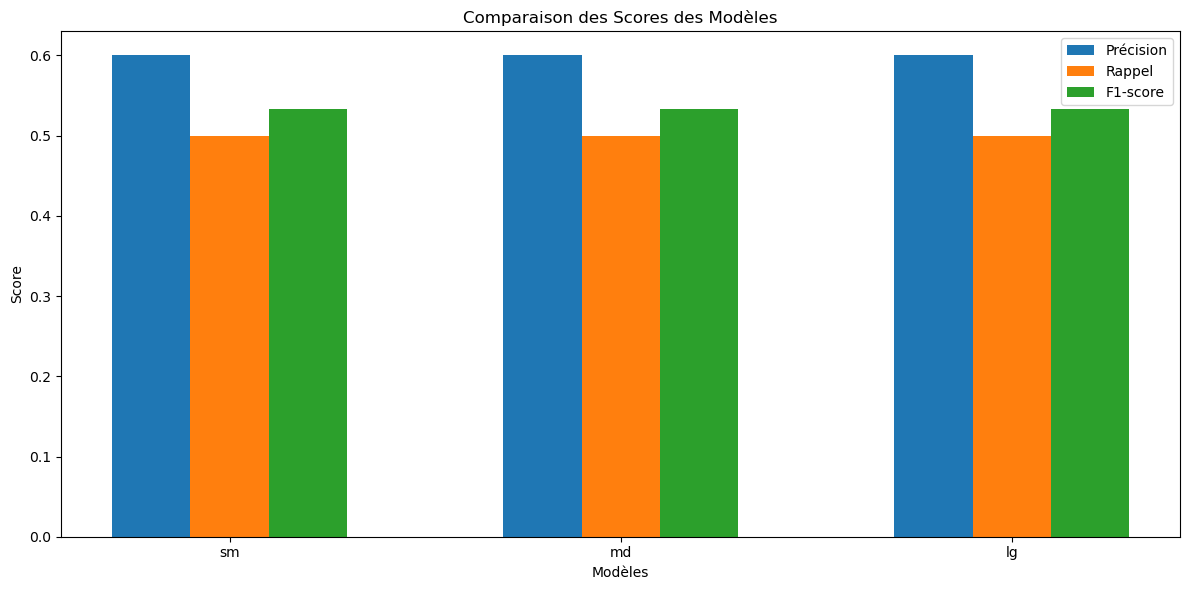

In [18]:
from collections import Counter
import matplotlib.pyplot as plt

# Extraction des entités d'un document
def extract_entities(doc):
    return [(ent.text, ent.label_) for ent in doc.ents]

# Comparaison des modèles
def compare_models(model_paths, texts, ground_truths):
    results = {key: [] for key in models.keys()}

    for text in texts:
        for model_key, model_path in model_paths.items():
            doc = load_and_test_model(model_path, text)
            entities = extract_entities(doc)
            results[model_key].append(entities)

    return results

# Comparaison et les annotations de référence
texts_to_compare = [
    '''Je souhaite me rendre à Lille en partant d'Aubervilliers pour assister à une conférence.''',
    '''Je compte me rendre à Bordeaux depuis Marseille pour rendre visite à ma soeur Paris.''',
    '''Je dois regarder les trains Toulouse - Brest pour aller voir mon ami Albert.''',
    '''Je dois planifier un voyage Nice Toulouse pour les prochaines vacances.''',
    '''Une réunion de travail m'oblige à faire Paris - Clermont-Ferrand la semaine prochaine.'''
]
ground_truths = [
    [('Aubervilliers', 'DEPARTURE'), ('Lille', 'DESTINATION')],
    [('Marseille', 'DEPARTURE'), ('Bordeaux', 'DESTINATION')],
    [('Toulouse', 'DEPARTURE'), ('Brest', 'DESTINATION')],
    [('Nice', 'DEPARTURE'), ('Toulouse', 'DESTINATION')],
    [('Paris', 'DEPARTURE'), ('Clermont-Ferrand', 'DESTINATION')]
]

# Analyse des résultats et calcul des métriques
def analyze_results(results, ground_truths):
    metrics = {key: {'precision': [], 'recall': [], 'f1_score': []} for key in models.keys()}

    for model_key, model_results in results.items():
        for predicted, true in zip(model_results, ground_truths):
            true_set = set(true)
            pred_set = set(predicted)

            true_positive = len(true_set & pred_set)
            false_positive = len(pred_set - true_set)
            false_negative = len(true_set - pred_set)

            precision = true_positive / (true_positive + false_positive) if true_positive + false_positive > 0 else 0
            recall = true_positive / (true_positive + false_negative) if true_positive + false_negative > 0 else 0
            f1_score = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

            metrics[model_key]['precision'].append(precision)
            metrics[model_key]['recall'].append(recall)
            metrics[model_key]['f1_score'].append(f1_score)

    # on calcul les moyennes pour chaque métrique
    for model_key in metrics:
        for metric in metrics[model_key]:
            metrics[model_key][metric] = sum(metrics[model_key][metric]) / len(metrics[model_key][metric])
        print(f"\nModèle : {model_key}")
        print(f"  Précision moyenne: {metrics[model_key]['precision']:.2f}")
        print(f"  Rappel moyen: {metrics[model_key]['recall']:.2f}")
        print(f"  F1-score moyen: {metrics[model_key]['f1_score']:.2f}")

    return metrics

# Comparaison des modèles
model_paths = {key: f"../../models/saved_models/{key}/model-best/" for key in models.keys()}
results = compare_models(model_paths, texts_to_compare, ground_truths)

metrics = analyze_results(results, ground_truths)

def plot_metrics(metrics):
    model_names = list(metrics.keys())
    precision_scores = [metrics[model]['precision'] for model in model_names]
    recall_scores = [metrics[model]['recall'] for model in model_names]
    f1_scores = [metrics[model]['f1_score'] for model in model_names]

    x = range(len(model_names))

    plt.figure(figsize=(12, 6))
    plt.bar(x, precision_scores, width=0.2, label='Précision', align='center')
    plt.bar([p + 0.2 for p in x], recall_scores, width=0.2, label='Rappel', align='center')
    plt.bar([p + 0.4 for p in x], f1_scores, width=0.2, label='F1-score', align='center')

    plt.xticks([p + 0.2 for p in x], model_names)
    plt.xlabel('Modèles')
    plt.ylabel('Score')
    plt.title('Comparaison des Scores des Modèles')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_metrics(metrics)